length of dataset:  10


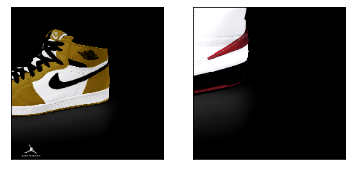

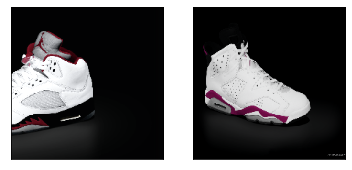

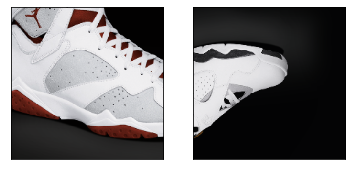

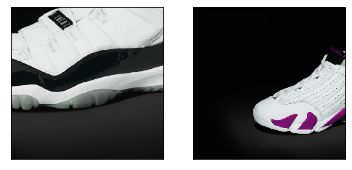

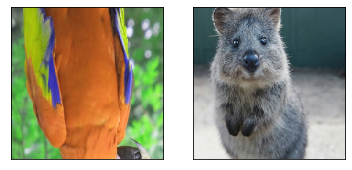

done!


In [2]:
import copy
import numpy as np
import os
import cv2
from matplotlib import pyplot as plt
import mxnet as mx
from mxnet import gluon
from mxnet.gluon.data import dataset
from mxnet.gluon.data.vision import transforms as T


def get_transform(transforms, is_training):
    transforms_list = []
    if is_training:
        transforms_list += transforms
    return T.Compose(transforms_list)


class MxGluonDataset(dataset.Dataset):
    def __init__(self, images_dir, transforms=None):
        # load all image files, sorting them to
        # ensure that they are aligned
        imgs = list(sorted(os.listdir(images_dir)))
        self.imgs = [os.path.join(images_dir, i) for i in imgs]
        self.transforms = transforms


    def __getitem__(self, index):
        path = self.imgs[index]
        label = None
        image = cv2.imread(path)
        image = mx.nd.array(image[:,:,::-1])
        if self.transforms is not None:
            image = self.transforms(image)
        image = T.image.imresize(image, 320, 320, interp=1)
        return image#, label


    def __len__(self):
        return len(self.imgs)


image_trans = [
    T.RandomResizedCrop(224, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=1),
    T.CenterCrop(224, interpolation=1),
    T.Resize(224, keep_ratio=False, interpolation=1),
    T.RandomFlipLeftRight(),
    T.RandomFlipTopBottom(),
    T.RandomBrightness(0.1), # Randomly jitters image brightness with a factor chosen from [max(0, 1 - brightness), 1 + brightness].
    T.RandomContrast(0.1), # Randomly jitters image contrast with a factor chosen from [max(0, 1 - contrast), 1 + contrast].
    T.RandomSaturation(0.1), # Randomly jitters image saturation with a factor chosen from [max(0, 1 - saturation), 1 + saturation].
    T.RandomHue(0.1), # Randomly jitters image hue with a factor chosen from [max(0, 1 - hue), 1 + hue].
    T.RandomColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), # Randomly jitters the brightness, contrast, saturation, and hue of an image.
    T.RandomLighting(0.1), # Add AlexNet-style PCA-based noise to an image.
]

 
images_dir = "../data"
batch_size = 2
shuffle = False
num_workers = 0
dataset = MxGluonDataset(images_dir, get_transform(image_trans, is_training=True))
print("length of dataset: ", len(dataset))


dataLoader = gluon.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, last_batch ="keep")

def mxgluontensor2ndarray(image):
    image = np.clip(image.asnumpy(),0,255)
    return image.astype(np.uint8)

for idx, item in enumerate(dataLoader):
    images = item
    plt.figure()
    for i in range(1,images.shape[0]+1):
        plt.subplot(1,batch_size,i)
        plt.imshow(mxgluontensor2ndarray(images[i-1]))
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
print("done!")